In [92]:
import os, sys
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import talib as ta
from  historical_data.alpaca import AlpacaHistoricalData
from backtester.strategy import Strategy
from datetime import datetime, timedelta

In [124]:
ticker = 'BTC/USD'
asset_type = 'Crypto'
start = datetime.today() - timedelta(days=365)
end = datetime.today()
interval = 15
short_period = 12
long_period = 26
signal_period = 9
trend_period = 200
atr_period = 14
stop_loss_multiplier = 10
take_profit_multiplier = 40
trend_ema_offset = 8

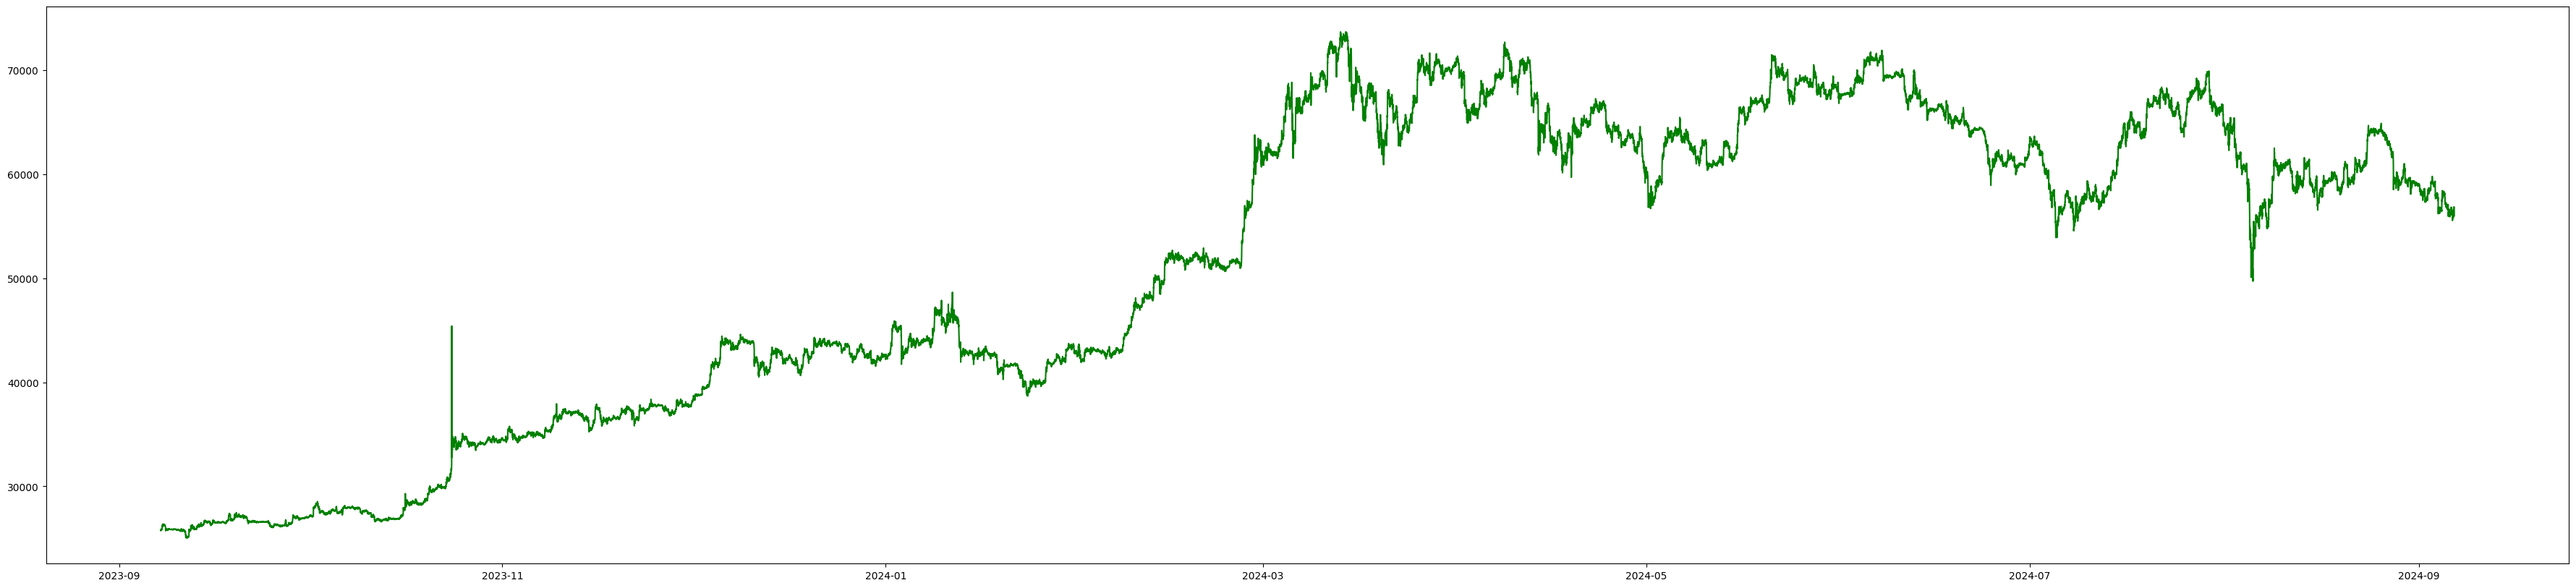

In [125]:
alpaca_data = AlpacaHistoricalData(ticker, assetType=asset_type, start=start, end=end, interval=interval)
data = alpaca_data.get_data()
alpaca_data.plot_data()


In [141]:
class MACDLongStrategy(Strategy):
    def __init__(self, data):
        super().__init__(data)
        self.data['Short EMA'] = ta.EMA(self.data['Close'], short_period)
        self.data['Long EMA'] = ta.EMA(self.data['Close'], long_period)
        self.data['ATR'] = ta.ATR(self.data['High'], self.data['Low'], self.data['Close'], atr_period) # ATR is used for setting stop loss
        self.data['Trend EMA'] = ta.EMA(self.data['Close'], trend_period) +  + (trend_ema_offset*self.data['ATR'])
        self.data['MACD Line'] = self.data['Short EMA'] - self.data['Long EMA']
        self.data['Signal Line'] = ta.EMA(self.data['MACD Line'], signal_period)
        self.data['Previous MACD Line'] = self.data['MACD Line'].shift()
        self.data['Previous Signal Line'] = self.data['Signal Line'].shift()
        self.data['Hist'] = self.data['MACD Line'] - self.data['Signal Line']
        self.data = self.data.dropna()
             
    def implement(self):
        self.data['Signal'] = 0
        for i in self.data.index:
            if self.position == 'Close':
                if (self.data.at[i, 'MACD Line'] > self.data.at[i, 'Signal Line']) & \
                    (self.data.at[i, 'Close'] > self.data.at[i, 'Trend EMA']):
                    buy_price = self.data['Close'][i]
                    stop_loss = buy_price - (stop_loss_multiplier * self.data.at[i, 'ATR'])
                    take_profit = buy_price + (take_profit_multiplier * self.data.at[i, 'ATR'])
                    self.data.at[i, 'Signal'] = 1
                    self.position = 'buy'
                    self.buy_trade(i, stop_loss=stop_loss, take_profit=take_profit)
            else:            
                if (self.data.at[i, 'Close'] <= self.stop_loss) | (self.data.at[i, 'Close'] >= self.take_profit):
                    self.close_trade(i)
                    self.data.at[i, 'Signal'] = 0
                    self.position = 'Close'
                else:
                    self.data.at[i, 'Signal'] = 1

    def plot_indicators(self):
        _, axis = plt.subplots(3, sharex=True, figsize=(45, 45))
        axis[0].set_title("Close Price Series") 
        axis[0].plot(self.data.index, self.data['Close'], color='black')
        axis[0].plot(self.data.index, self.data['Trend EMA'], color='green')
        axis[0].grid()
        axis[1].set_title("MACD and Signal Line") 
        axis[1].plot(self.data.index, self.data['MACD Line'], color='blue')
        axis[1].plot(self.data.index, self.data['Signal Line'], color='green')
        axis[1].grid()
        axis[2].set_title("MACD Histogram") 
        axis[2].bar(self.data['Hist'][self.data['Hist']>=0].index, self.data['Hist'][self.data['Hist']>=0], label='MACD Histogram', color='green', width = .001)
        axis[2].bar(self.data['Hist'][self.data['Hist']<0].index, self.data['Hist'][self.data['Hist']<0], label='MACD Histogram', color='red', width = .001)
        axis[2].grid()
        plt.show()

    def get_data(self):
        return self.data

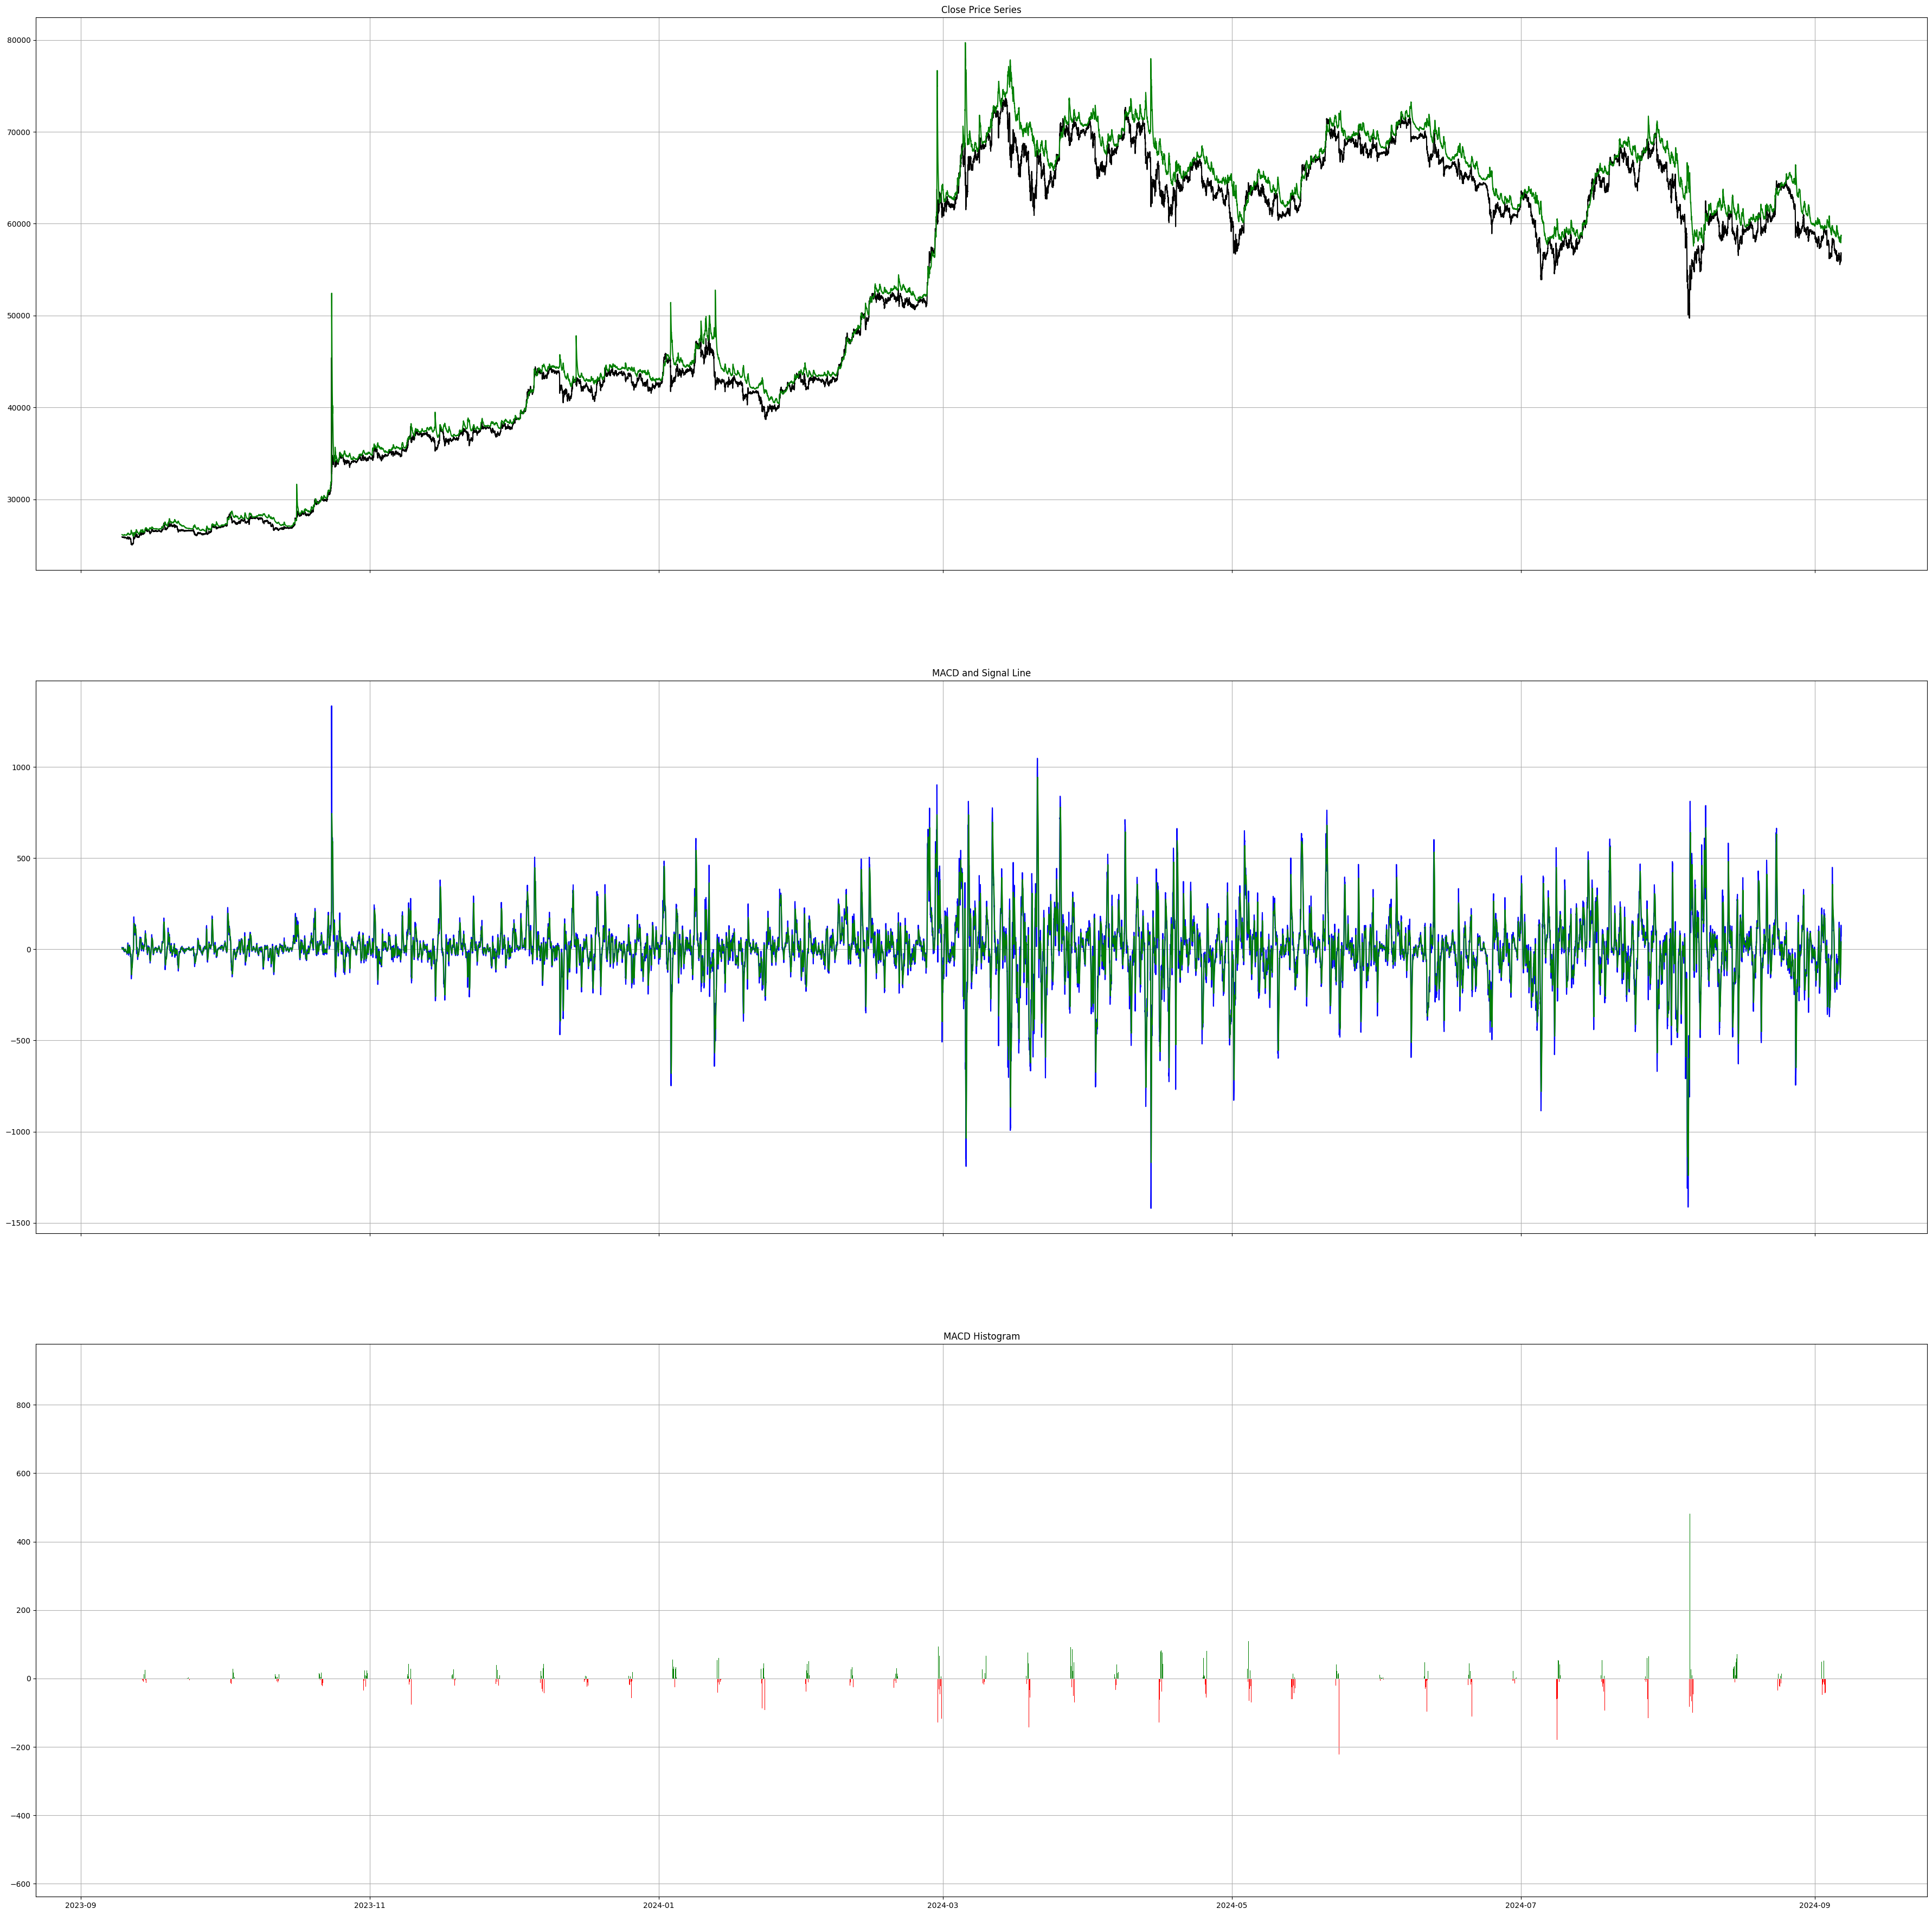

In [142]:
macdStrategy = MACDLongStrategy(data=data)
macdStrategy.plot_indicators()

/var/folders/9x/c8rnngl93m162n92399m4b6w0000gn/T/ipykernel_43500/3810199253.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Signal'] = 0


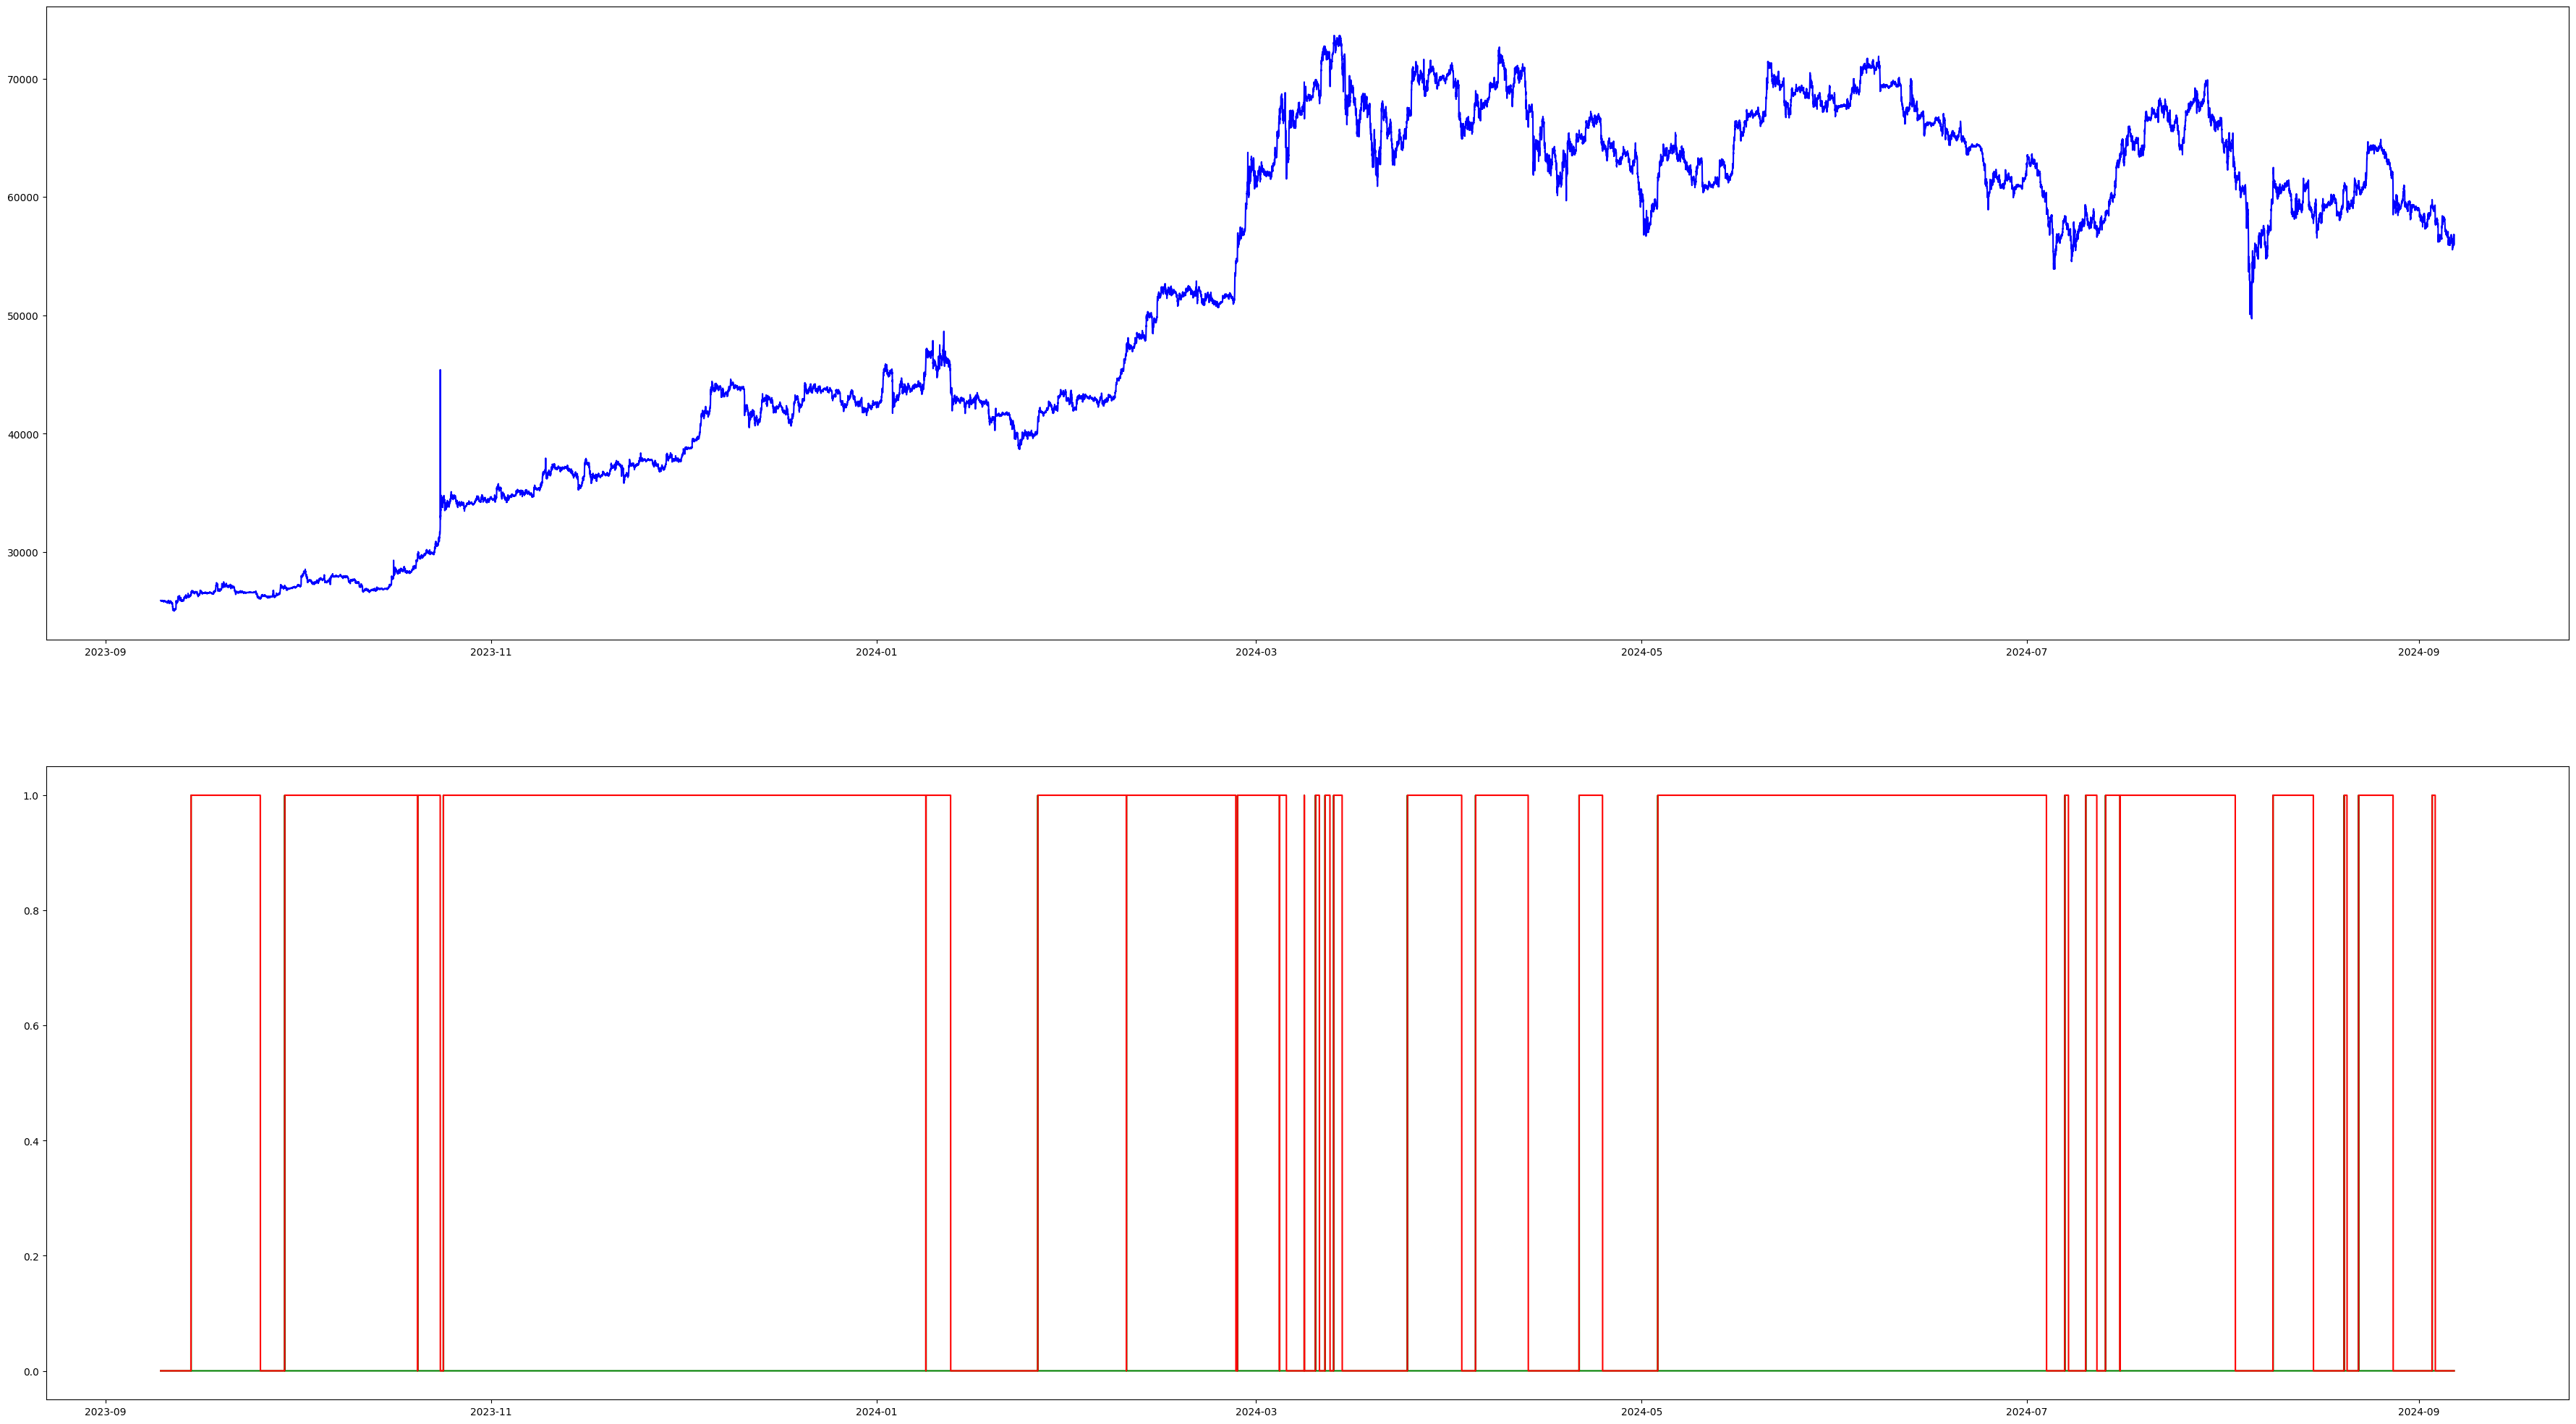

In [143]:
macdStrategy.implement()
macdStrategy.plot_positions()

/Users/snehil1998/Documents/Repos/trading-strategies/backtester/backtester.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Market Returns'] = self.data['Close'].pct_change().fillna(0)
/Users/snehil1998/Documents/Repos/trading-strategies/backtester/backtester.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Cumulative Strategy Returns'] = 0
/Users/snehil1998/Documents/Repos/trading-strategies/backtester/backtester.py:15: SettingWithCopyWarning: 
A value is trying to be set on a

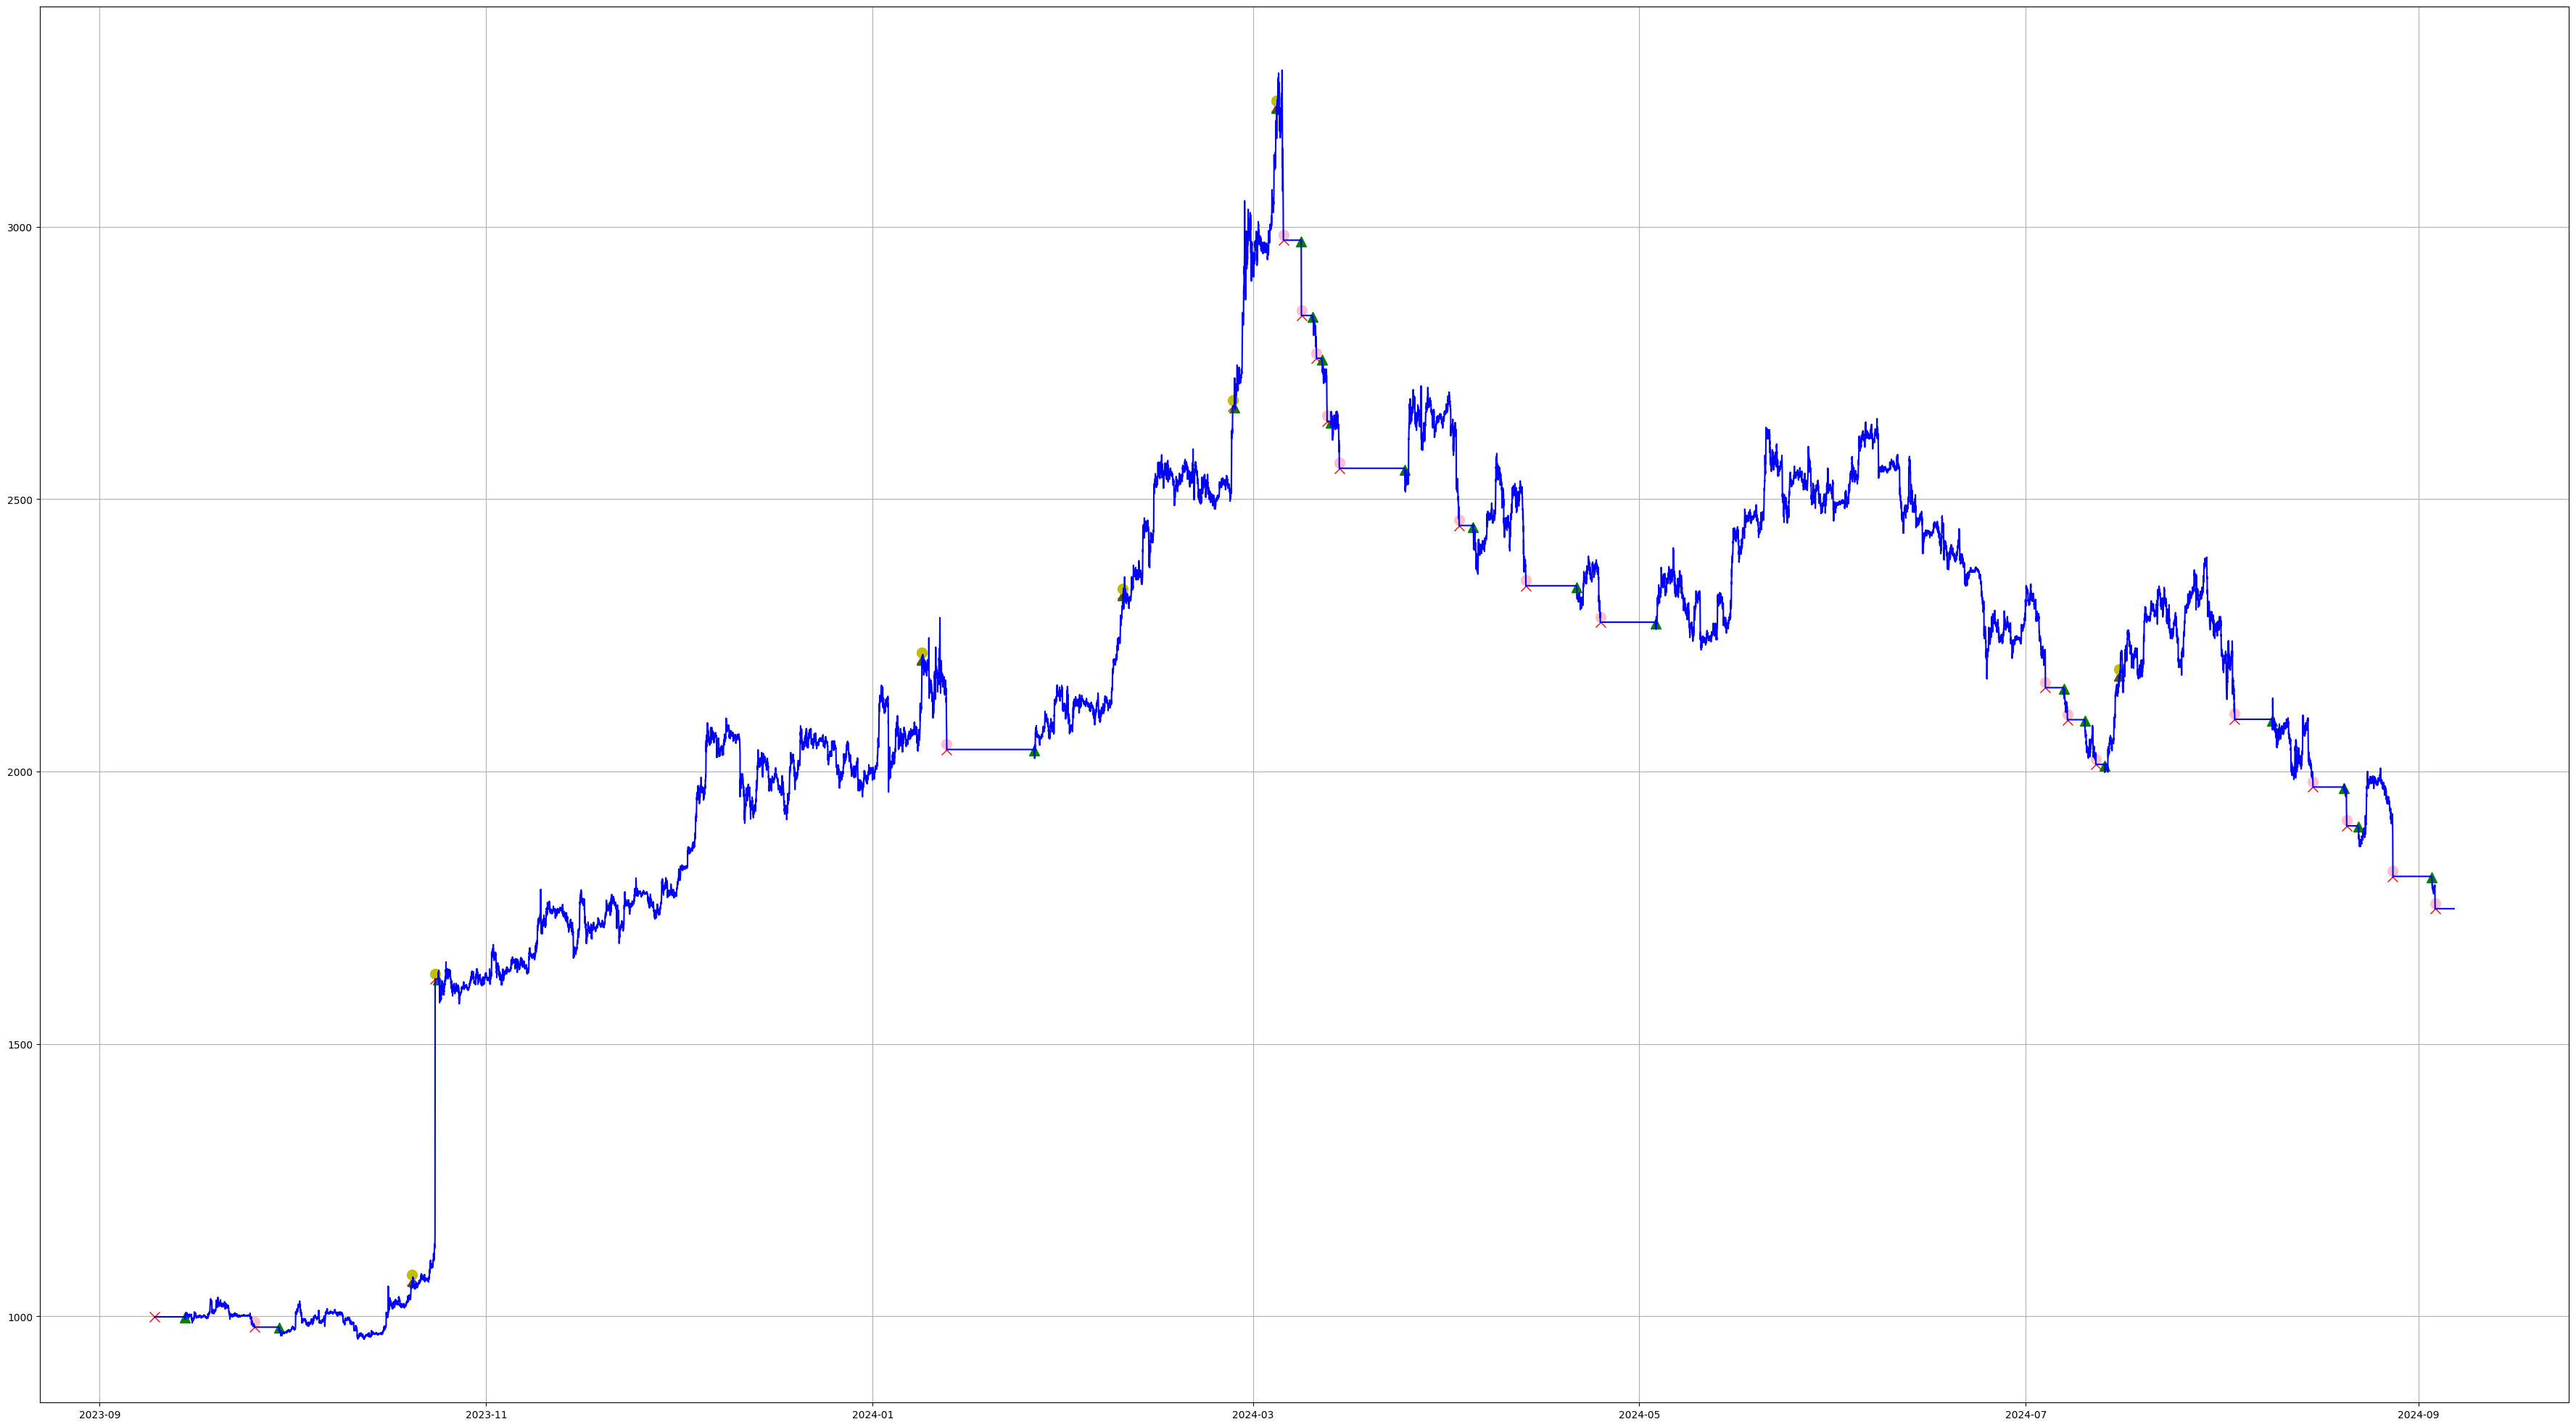

In [144]:
from backtester.backtester import Backtester

commission_percentage = 0.001
amount_invested = 1000
leverage = 1
updated_data = macdStrategy.get_data()


backtester = Backtester(macdStrategy, updated_data, trade_commission=commission_percentage, amount_invested=amount_invested, leverage_ratio=leverage)
backtester.backtest()
backtester.plot_backtest()

In [145]:
backtester.get_metrics()

Final value:  1748.0814709614285
P&L:  748.0814709614285
Returns %:  74.80814709614286
Number of trades:  25
Loss trades %:  72.0
Profit trades %:  28.0
Annual Sharpe ratio:  1.0318491433208974
Max profit %:  228.7341640395296
Max loss %:  -4.190607182404574


/Users/snehil1998/Documents/Repos/trading-strategies/backtester/backtester.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Final value: ', self.data['Cumulative Strategy Returns'][-1])
/Users/snehil1998/Documents/Repos/trading-strategies/backtester/backtester.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('P&L: ', (self.data['Cumulative Strategy Returns'][-1] - (self.leverage_ratio*self.amount_invested)))
/Users/snehil1998/Documents/Repos/trading-strategies/backtester/backtester.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys